# NLP Eda


Данная часть EDA посвящена анализу смысловой составляющей роликов, которые удалось извлечь расшифровок базы видео.

Цель - сделать подробный анализ представленного корпуса расшифровок видео

1. Определить языковую составляющую с помощью сторонней модели (**huggingface** - fast_langdetect`)
2. Построить основные статистические характеристики относительно корпуса:

    a) Средняя длина текста
   
    b) Размер токенизированного текста (сырого, после удаления стоп-слов, уникальных токенов)
 
4. Осуществить описательный анализ с помощью техник Bag of Words и Word Cloud

In [1]:
import os
import pathlib

ROOT_PATH = pathlib.Path().resolve().parent
print(ROOT_PATH)



/Users/andrey/PycharmProjects/vector-search-hse


In [2]:
import pandas as pd

df = pd.read_parquet(ROOT_PATH / 'data/aggregated_text.parquet')
df.head()

,filename,text
0,FullSizeRender.tsv,字幕志愿者 李宗盛
1,IMG_0703.tsv,This is the most dangerous strike in mixed mar...
2,IMG_0704.tsv,"So this puzzle is a little harder, but let's g..."
3,IMG_0705.tsv,I want to talk about the lie of cultural appro...
4,IMG_0706.tsv,"J'cale le pétard entre mes dents Bah ouais, ba..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  333 non-null    object
 1   text      333 non-null    object
dtypes: object(2)
memory usage: 5.3+ KB


# Извлечение информации из текстов

In [4]:
df['n_tokens'] = df['text'].apply(lambda x: len(x.split()))
df['length'] = df['text'].apply(lambda x: len(x))

df.describe()

,n_tokens,length
count,333.000000,333.000000
mean,226.147147,1224.684685
std,298.405117,1643.396468
min,1.000000,1.000000
25%,22.000000,127.000000
50%,146.000000,760.000000
75%,295.000000,1632.000000
max,1854.000000,10465.000000


Text(0.5, 1.0, 'Histogram of n_tokens')

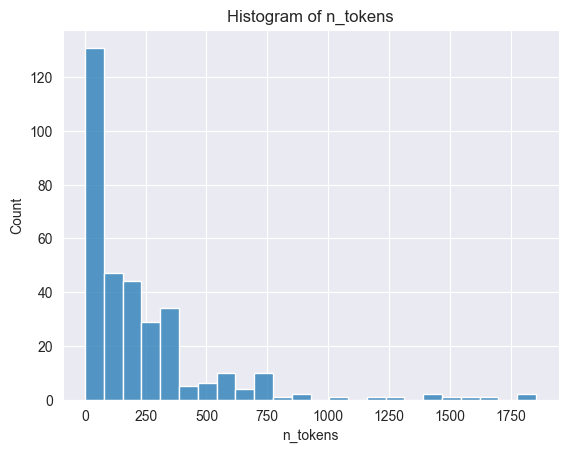

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df['n_tokens']).set_title('Histogram of n_tokens')

Text(0.5, 1.0, 'Histogram of text length')

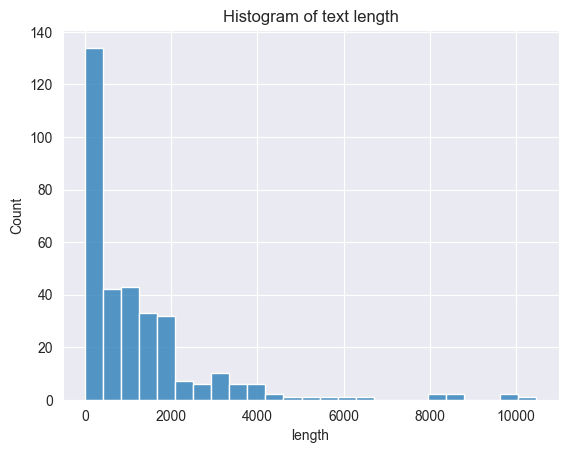

In [6]:
sns.histplot(data=df['length']).set_title('Histogram of text length')

# Определение языков

Для определения происхождения языка в представленных текстах воспользуемся библиотекой fast-lang-detect

In [7]:
from fast_langdetect import detect
from tqdm import tqdm

texts = list(df['text'])

detections = []
for text in tqdm(texts):
    detection = detect(text, model="auto", k=1)
    detections.append(*detection)

/Users/andrey/PycharmProjects/vector-search-hse/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 333/333 [00:00<00:00, 4614.38it/s]


In [8]:
if not 'lang' in df.columns:
    df = pd.concat([df, pd.DataFrame.from_records(detections)], axis=1)

In [9]:
df

,filename,text,n_tokens,length,lang,score
0,FullSizeRender.tsv,字幕志愿者 李宗盛,2,9,zh,0.993031
1,IMG_0703.tsv,This is the most dangerous strike in mixed mar...,171,877,en,0.850605
2,IMG_0704.tsv,"So this puzzle is a little harder, but let's g...",142,760,en,0.981890
3,IMG_0705.tsv,I want to talk about the lie of cultural appro...,716,3971,en,0.983911
4,IMG_0706.tsv,"J'cale le pétard entre mes dents Bah ouais, ba...",45,235,fr,0.932815
...,...,...,...,...,...,...
328,IMG_1923.tsv,That is why you never try to spell Mississippi...,157,915,en,0.944783
329,IMG_1926.tsv,Why are there kids painting in the streets on ...,490,2880,en,0.960431
330,IMG_1929.tsv,and for today's experiment we're going with ba...,180,922,en,0.948105
331,IMG_1930.tsv,Thank you.,2,10,en,0.987681


In [10]:
df.groupby('lang')['text'].agg('count')

lang
en    301
es      1
fr      6
id      1
ja      4
ko      1
ms      1
pt      2
ru     13
zh      3
Name: text, dtype: int64

Для дальнейшего анализа предлагаем взять только расшифровки видео на английском языке

In [11]:
df_corp = df[df['lang'] == 'en']
df_corp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, 1 to 332
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  301 non-null    object 
 1   text      301 non-null    object 
 2   n_tokens  301 non-null    int64  
 3   length    301 non-null    int64  
 4   lang      301 non-null    object 
 5   score     301 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 16.5+ KB


# Corpus Processing

В рамках данного блока предлагаем провести обработку и подготовку текстов:
- Осуществить базовый препроцессинг
- Исключить стоп-слова
- Подсчитать количество токенов после удаления стоп-слов
- Кол-во уникальных токенов 

In [52]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
import re

def clean_text(text):
    # Регулярное выражение позволяет оставить только буквы и цифры
    cleaned = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    cleaned = ' '.join([token for token in cleaned.split() if len(token) > 1])
    return cleaned.lower()

def tokenize(text: str) -> list[str]:
    return text.split()

In [54]:
texts = list(df_corp['text'])

preprocessed_texts = [clean_text(text) for text in texts]

df_corp['preprocessed_text'] = preprocessed_texts
df_corp['tokenized_text'] = df_corp['preprocessed_text'].apply(tokenize)

/var/folders/nk/l18kdz4d3bzcfy29kv786cgw0000gn/T/ipykernel_18590/3224926789.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corp['preprocessed_text'] = preprocessed_texts
/var/folders/nk/l18kdz4d3bzcfy29kv786cgw0000gn/T/ipykernel_18590/3224926789.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corp['tokenized_text'] = df_corp['preprocessed_text'].apply(tokenize)


In [55]:
corpus = [word for text in preprocessed_texts for word in tokenize(text)]
corpus[:10]

['this',
 'is',
 'the',
 'most',
 'dangerous',
 'strike',
 'in',
 'mixed',
 'martial',
 'arts']

Text(0.5, 1.0, 'Most Frequent Words (without stop words)')

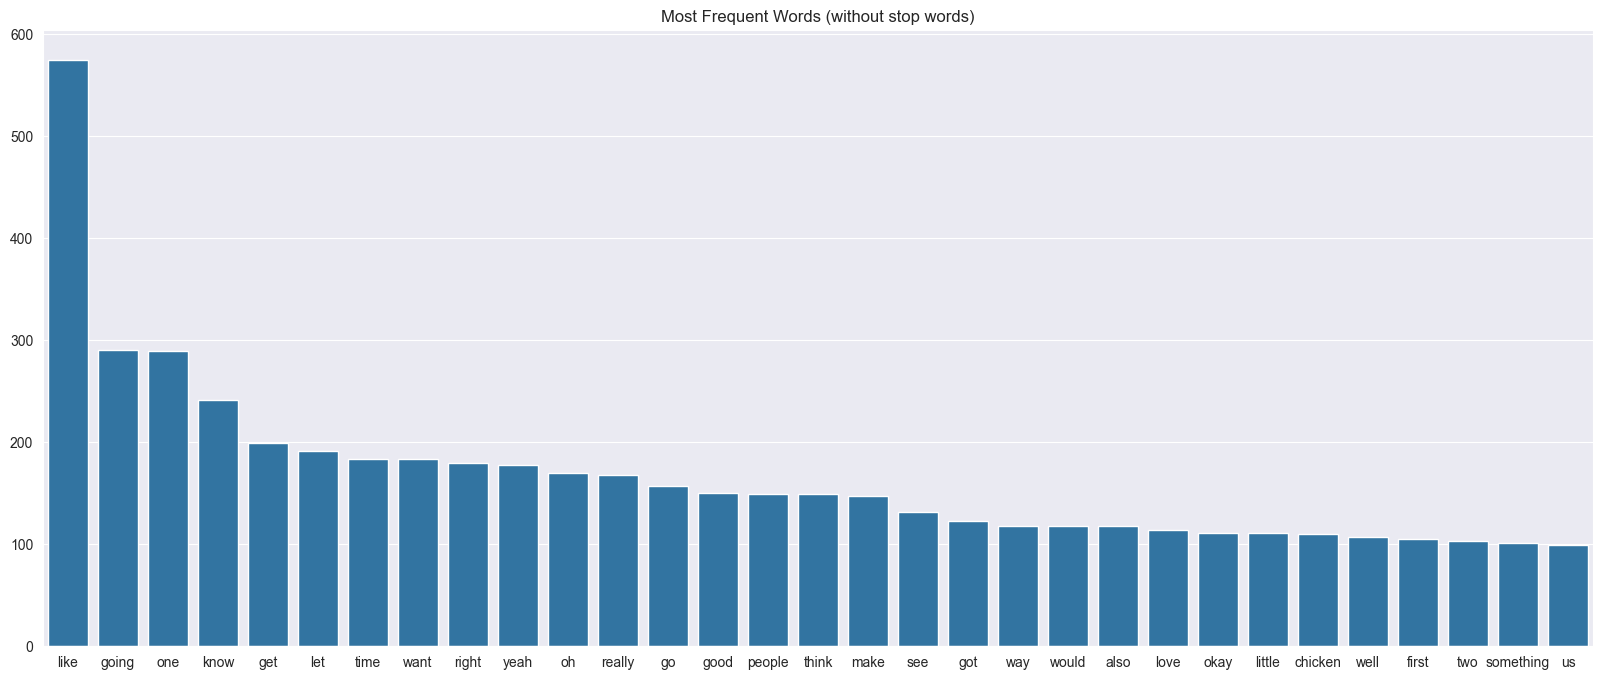

In [56]:
from collections import Counter

top_k = 30
counter = Counter(corpus)

x, y = [], []
for word, count in counter.most_common():
    if (word not in stop):
        x.append(word)
        y.append(count)

    if len(x) > top_k:
        break

plt.figure(figsize=(20, 8))
sns.barplot(x=x, y=y).set_title('Most Frequent Words (without stop words)')

## Stop Words

[Text(0.5, 1.0, 'Top 30 StopWords')]

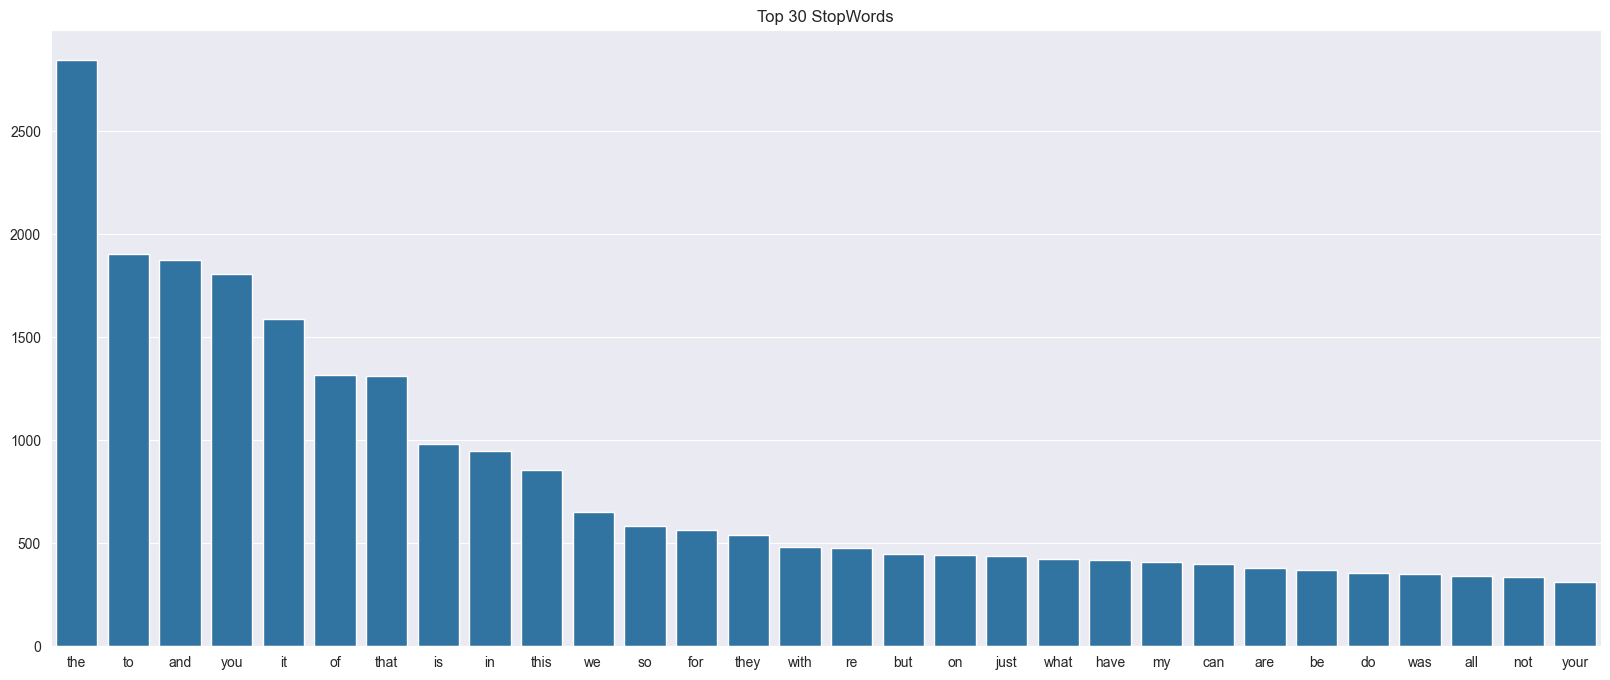

In [57]:
stopwords = Counter()
for word in corpus:
    if word in stop:
        stopwords[word] += 1

top_k = 30
words, counts = zip(*stopwords.most_common(top_k))

plt.figure(figsize=(20, 8))
sns.barplot(x=words, y=counts).set(title='Top 30 StopWords')

In [58]:
# Filter stop Words

def filter_tokens(tokens: list[str]) -> str:
    toks = []
    for word in tokens:
        if word not in stopwords:
            toks.append(word)
    return toks

# Фильтрация и подсчет слов после фильтрации
df_corp['filtered_tokens'] = df_corp['tokenized_text'].apply(filter_tokens)
df_corp['filtered_n_tokens'] = df_corp['filtered_tokens'].apply(lambda x: len(x))
df_corp['filtered_n_tokens'].describe()

/var/folders/nk/l18kdz4d3bzcfy29kv786cgw0000gn/T/ipykernel_18590/2534823693.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corp['filtered_tokens'] = df_corp['tokenized_text'].apply(filter_tokens)
/var/folders/nk/l18kdz4d3bzcfy29kv786cgw0000gn/T/ipykernel_18590/2534823693.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corp['filtered_n_tokens'] = df_corp['filtered_tokens'].apply(lambda x: len(x))


count    301.000000
mean     115.425249
std      142.972533
min        0.000000
25%       14.000000
50%       78.000000
75%      156.000000
max      971.000000
Name: filtered_n_tokens, dtype: float64

In [59]:
# Фильтрация и подсчет слов после фильтрации
df_corp['unique_tokens'] = df_corp['filtered_tokens'].apply(set)
df_corp['unique_n_tokens'] = df_corp['unique_tokens'].apply(lambda x: len(x))
df_corp['unique_n_tokens'].describe()

/var/folders/nk/l18kdz4d3bzcfy29kv786cgw0000gn/T/ipykernel_18590/2911471774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corp['unique_tokens'] = df_corp['filtered_tokens'].apply(set)
/var/folders/nk/l18kdz4d3bzcfy29kv786cgw0000gn/T/ipykernel_18590/2911471774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corp['unique_n_tokens'] = df_corp['unique_tokens'].apply(lambda x: len(x))


count    301.000000
mean      76.003322
std       80.320753
min        0.000000
25%       10.000000
50%       61.000000
75%      107.000000
max      541.000000
Name: unique_n_tokens, dtype: float64

In [60]:
df_corp[['unique_n_tokens', 'filtered_n_tokens', 'n_tokens']].describe()

,unique_n_tokens,filtered_n_tokens,n_tokens
count,301.000000,301.000000,301.000000
mean,76.003322,115.425249,238.073090
std,80.320753,142.972533,298.317015
min,0.000000,0.000000,1.000000
25%,10.000000,14.000000,28.000000
50%,61.000000,78.000000,155.000000
75%,107.000000,156.000000,319.000000
max,541.000000,971.000000,1854.000000


# Базовая информация по кол-ву токенов
Просто токены (без фильтров): mean - 238, median - 155

Токены после фильтрации стоп-слов: mean - 115, median - 156

Уникальные токены после фильтрации стоп-слов: mean - 76, median - 61

[Text(0.5, 1.0, 'Tokens Histogram after Filtration')]

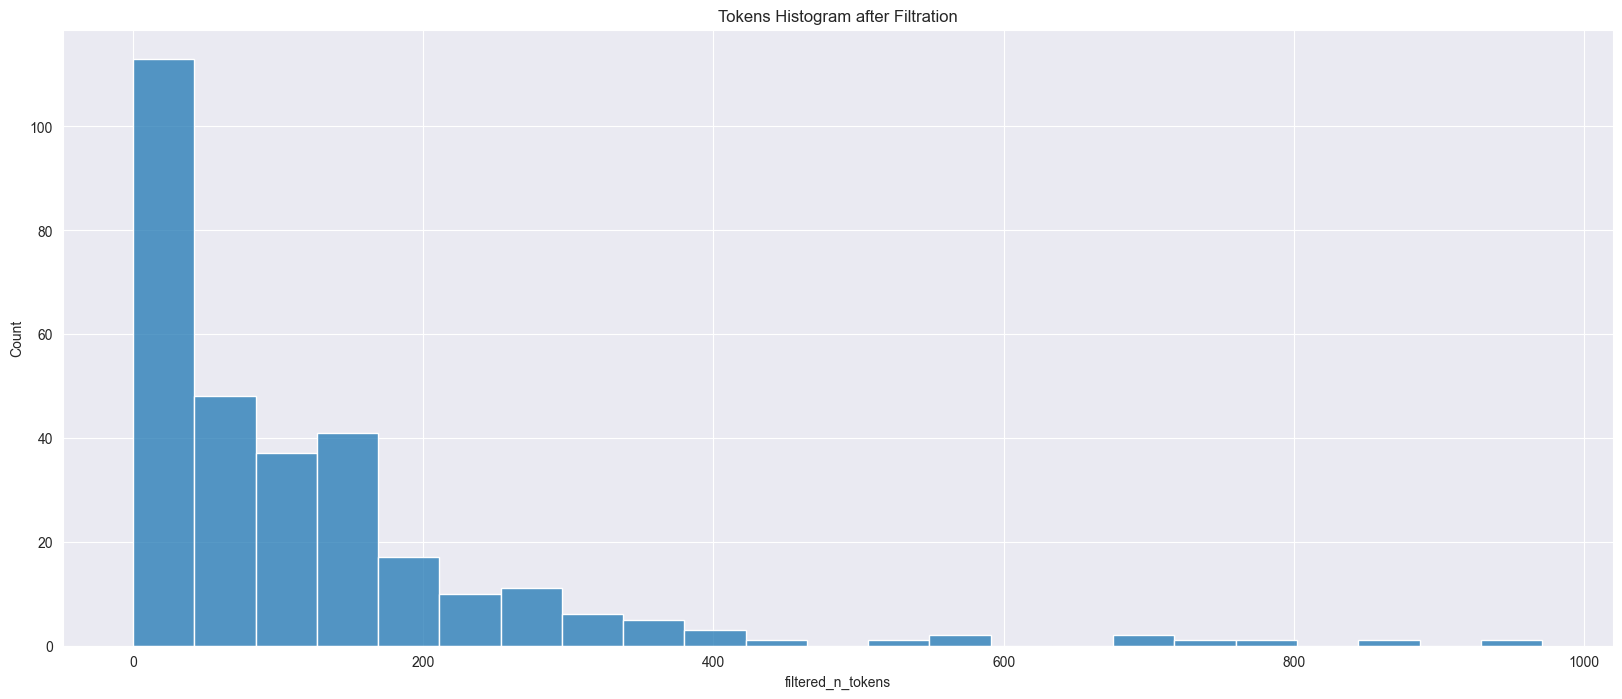

In [61]:
plt.figure(figsize=(20, 8))
sns.histplot(x=df_corp['filtered_n_tokens']).set(title='Tokens Histogram after Filtration')

[Text(0.5, 1.0, 'Unique Tokens Histogram')]

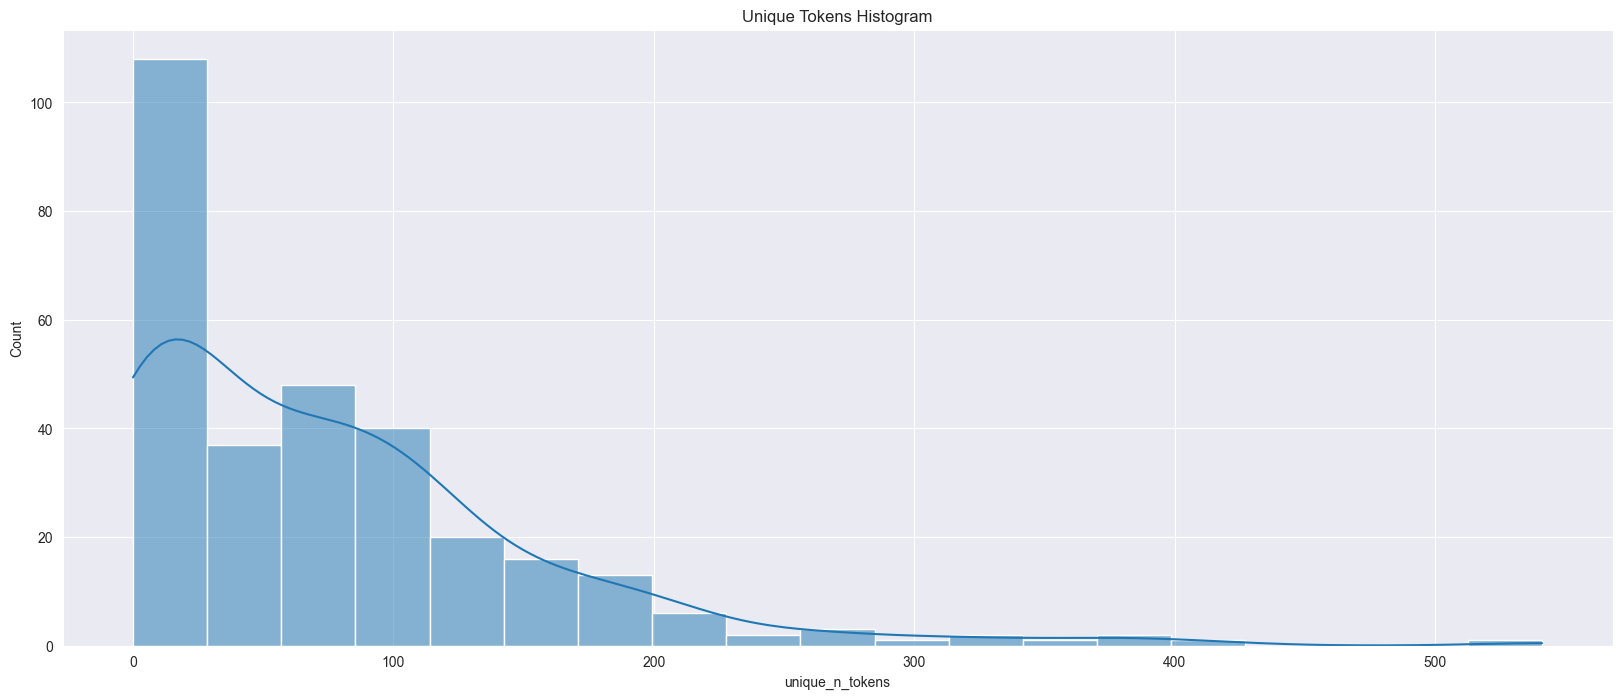

In [62]:
plt.figure(figsize=(20, 8))
sns.histplot(
    x=df_corp['unique_n_tokens'],
    kde=True,
).set(title='Unique Tokens Histogram')

In [ ]:
df_corp.head()

# Основные выводы

Общее количество текстов - 333

Из них на английском - 301 

Средняя длина 226 (слов) 1224 (символов)

После фильтрации с помощью nltk и stopwords

*Количество токенов*

Просто токены (без фильтров): mean - 238, median - 155

Токены после фильтрации стоп-слов: mean - 115, median - 156

Уникальные токены после фильтрации стоп-слов: mean - 76, median - 61


# Фильтрация

Для последующего анализа с помощью тематичекого моделирования мы предлагаем отфильтровать наши видео по количеству токенов на уровне 1% самых коротких и самых длинных видео.

Для этого сделаем неблокирующую разметку (флаг)

In [68]:
import numpy as np

thr_bot = max(np.percentile(df_corp['unique_n_tokens'], 1), 5)
thr_top = np.percentile(df_corp['unique_n_tokens'], 99)
print('Порог для токенов снизу (1%): ', thr_bot)
print('Порог для токенов сверху (99%): ', thr_top)

Порог для токенов снизу (1%):  5
Порог для токенов сверху (99%):  375.0


In [69]:
df_corp['is_valid'] = False
df_corp.loc[(df_corp['unique_n_tokens'] >= thr_bot) & (df_corp['unique_n_tokens'] < thr_top), 'is_valid'] = True

df_corp.head()

/var/folders/nk/l18kdz4d3bzcfy29kv786cgw0000gn/T/ipykernel_18590/2428092098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corp['is_valid'] = False


,filename,text,n_tokens,length,lang,score,preprocessed_text,tokenized_text,filtered_tokens,filtered_n_tokens,unique_tokens,unique_n_tokens,is_valid
1,IMG_0703.tsv,This is the most dangerous strike in mixed mar...,171,877,en,0.850605,this is the most dangerous strike in mixed mar...,"[this, is, the, most, dangerous, strike, in, m...","[dangerous, strike, mixed, martial, arts, hamm...",78,"{strike, whole, moat, right, pull, shot, time,...",67,True
2,IMG_0704.tsv,"So this puzzle is a little harder, but let's g...",142,760,en,0.981890,so this puzzle is little harder but let give i...,"[so, this, puzzle, is, little, harder, but, le...","[puzzle, little, harder, let, give, go, mitten...",73,"{added, let, new, two, bridge, link, issues, d...",62,True
3,IMG_0705.tsv,I want to talk about the lie of cultural appro...,716,3971,en,0.983911,want to talk about the lie of cultural appropr...,"[want, to, talk, about, the, lie, of, cultural...","[want, talk, lie, cultural, appropriation, whi...",341,"{ignorant, believe, leave, much, lie, video, a...",200,True
5,IMG_0707.tsv,"I was like, oh girl, shock it, I can't let you...",36,157,en,0.988990,was like oh girl shock it can let you care sav...,"[was, like, oh, girl, shock, it, can, let, you...","[like, oh, girl, shock, let, care, save, girl,...",18,"{let, fall, turn, like, care, save, oh, eyes, ...",10,True
6,IMG_0708.tsv,I Thank you. Thank you.,5,23,en,0.991097,thank you thank you,"[thank, you, thank, you]","[thank, thank]",2,{thank},1,False


In [70]:
df_corp.groupby('is_valid')['text'].agg('count')

is_valid
False     48
True     253
Name: text, dtype: int64

In [71]:
df_corp.to_parquet(ROOT_PATH / 'data/corpora.parquet', index=False)

PosixPath('/Users/andrey/PycharmProjects/vector-search-hse')